# Import libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
from mpl_toolkits import mplot3d
from scipy.integrate import cumtrapz
from scipy.interpolate import griddata
from sklearn.decomposition import PCA
import os
import pickle
from pyfuncs import *

import time as st

startdir = '/Users/leo/Desktop/ResearchPhD/PitchControl/analysis/'
%qtconsole

# Read in selected data, combine into one large dataframe

In [2]:
runDates = ['20210803_1','20210816','20210817_1','20210818_1']

# Load dataframes
os.chdir(os.path.join(startdir,'preprocessedCache'))
for i,d in enumerate(runDates):
    dtemp = pd.read_hdf(d+'.h5')
    dtemp['date'] =  d
    if i==0:
        df = dtemp
    else:
        df = df.append(dtemp)
# Load other relevant variables
file = open(os.path.join(startdir, 'preprocessedCache', 'vars')+'.pkl', 'rb')
translations, runDates = pickle.load(file)
file.close()
# Important information that I'll just hard-code in
channelsEMG = ['LDVM', 'LDLM', 'RDLM', 'RDVM']
channelsFT = ['fx', 'fy', 'fz', 'mx', 'my', 'mz']
fsamp = 10000
# Recreate first spike columns because I don't trust them
for m in channelsEMG:
    df[m+'_fs'] = 0
    df[m+'_fs'] = df.groupby(['date','pulse','wb'], group_keys=False).apply(
        lambda g: g[m+'_fs'] + (g[m+'_st'].idxmax() - g[m+'_st'].idxmin()))
# Define tDVM-tDLM columns
df['tdl'] = (df['LDVM_fs']-df['LDLM_fs'])/10
df['tdr'] = (df['RDVM_fs']-df['RDLM_fs'])/10
df.loc[(df['tdl']<0), 'tdl'] = np.nan
df.loc[(df['tdr']<0), 'tdr'] = np.nan


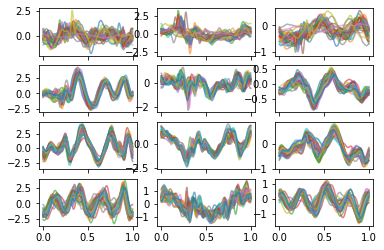

In [8]:
# Quick test plot
fig, ax = plt.subplots(len(runDates), 3, sharex=True)
for i,d in enumerate(runDates):
    dt = df.loc[df.date==d].copy()
    dt = dt.loc[dt.pulse==dt.pulse.iloc[0]]
    for j,m in enumerate(channelsFT[3:]):
        for jj in np.unique(dt['wb']):
            ax[i,j].plot(dt.loc[dt['wb']==jj, 'phase'], dt.loc[dt['wb']==jj, m], alpha=0.6)

# Torques in quiescent moth trials used to make COM translations
Works as a check to indicate that COM has been found: All torques plotted should be minimized to center around 0

In [ ]:
readFrom = 'dropbox'
fig, ax = plt.subplots(len(runDates), 1, sharex=True, sharey=True)
for ii,date in enumerate(runDates):
    # Read empty FT for bias
    biasmat, _, fsamp = readRaw(date, 'empty', doFT=True, readFrom=readFrom)
    bias = biasmat.mean(axis=0)[1:-1]
    # Use quiescent moth from stim characterization to find translation to COM
    charTrials = whichTrials(date, purpose='char', readFrom=readFrom)
    M, _, _ = readRaw(date, str(charTrials[0]).zfill(3), doFT=True, readFrom=readFrom)
    mat = M.mean(axis=0)[1:-1]
    # Apply calibration matrix and bias, get mean forces and torques for quiescent moth
    meanFT = transformFTdata((mat-bias).transpose(), M_trans=np.identity(6))
    lx,ly,lz = translations[runDates.index(date)].x
    lz = lz+20
    M_trans = np.array([
        [1,0,0,0,0,0],
        [0,1,0,0,0,0],
        [0,0,1,0,0,0],
        [0, lz, -ly, 1, 0, 0],
        [-lz, 0, lx, 0, 1, 0],
        [ly, -lx, 0, 0, 0, 1]
        ])
    new = transformFTdata((M[:,1:7]-bias).transpose(), M_trans=M_trans)
    for i in range(3):
        ax[ii].plot(M[:,0], new[:,3+i])
ax[len(runDates)-1].set_xlabel('Time (s)')
ax[0].set_ylim((-0.5,0.5))
[translations[i].x for i in range(len(runDates))]

# Look for ways to split by upstroke and downstroke

Why not split upstroke and downstroke (or, at least, split the wingstroke into halves) by taking the other points where the hilbert transform angle flips across zero?

# Estimating "actual pitch" from pitch torque

I am slightly suspicious of this, partially because I don't trust that we've actually transformed FT matrix to be at the real COM, especially going from individual to individual. How much would that throw off this analysis? Do we have stronger ways to verify?

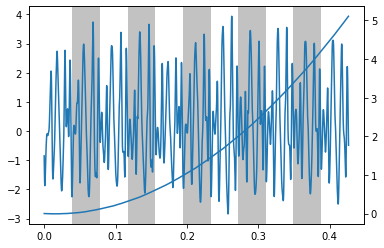

In [114]:
dt = df.loc[(df.date=='20210817_1') & 
            (df.pulse==1) & 
            (df.wb>=-5) & 
            (df.wb<=5),].copy()
dt.Time -= dt.Time.iloc[0]

Iyy = 266.7/1000/(1000**2) # gmm^2 to kg m^2

plt.figure()
time = dt.Time.to_numpy()
mx = dt.mx
theta = cumtrapz(cumtrapz(mx/1000/Iyy, dx=1/fsamp), dx=1/fsamp)*180/np.pi
for j in np.unique(dt['wb']):
    if j % 2 == 0:
        wbtime = dt.loc[dt['wb']==j, 'Time'].to_numpy()
        plt.axvspan(wbtime[0], wbtime[-1], lw=0, color='#C2C2C2')
plt.plot(time, dt.mx)
ax1 = plt.gca()
ax2 = ax1.twinx()
ax2.plot(time[1:-1], theta)

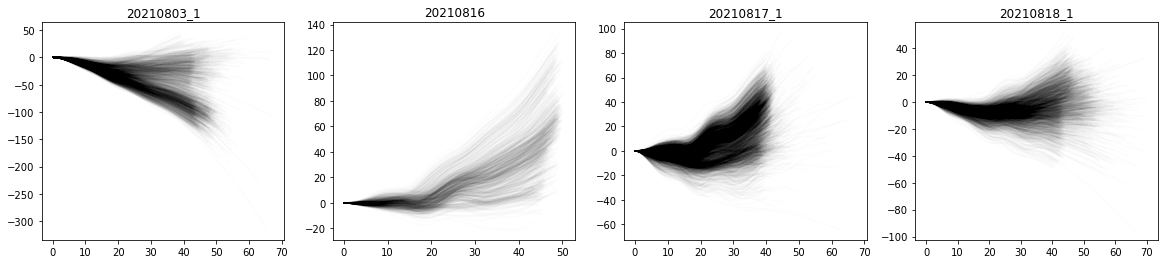

In [26]:
Iyy = 266.7/1000/(1000**2) # gmm^2 to kg m^2

fig, ax = plt.subplots(1, len(runDates), figsize=(20,4))

for i, (dname, dg) in enumerate(df.groupby('date')):
    for name, g in dg.groupby(['pulse','wb']):
        theta = cumtrapz(cumtrapz(g.mx/1000/Iyy, dx=1/fsamp), dx=1/fsamp)*180/np.pi
        ax[i].plot(1000*(g.Time.iloc[:-2]-g.Time.iloc[0]), theta, color='black', alpha=0.01)
    ax[i].set_title(dname)

# Linear model appraoch

- Smaller windows to apply summary stats (like means) on 
- 

# Phase-aligned vs. spike-aligned torque waveforms

Inspired by figure 2 of Simon's 2015 PLS paper; compare waveform alignment when aligned by wingbeat phase (zero crossing of hilbert transform) vs when aligned by first spike timing of a given muscle

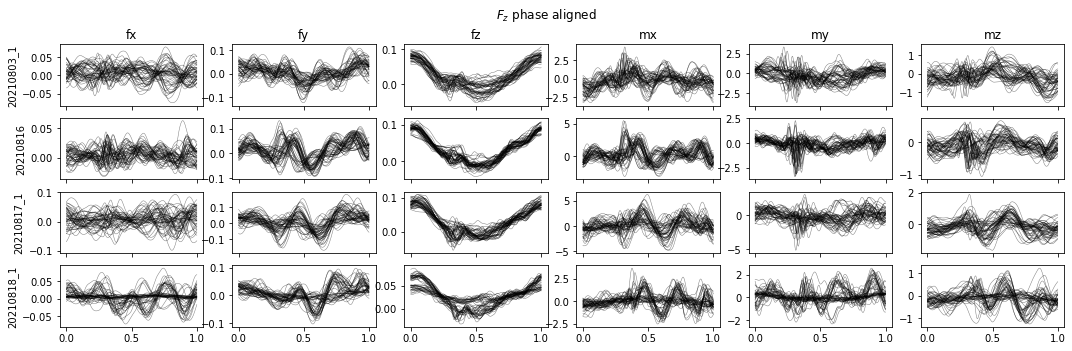

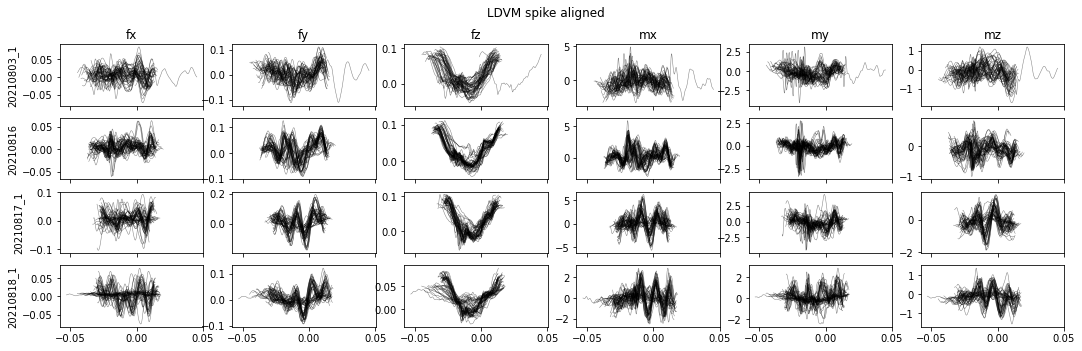

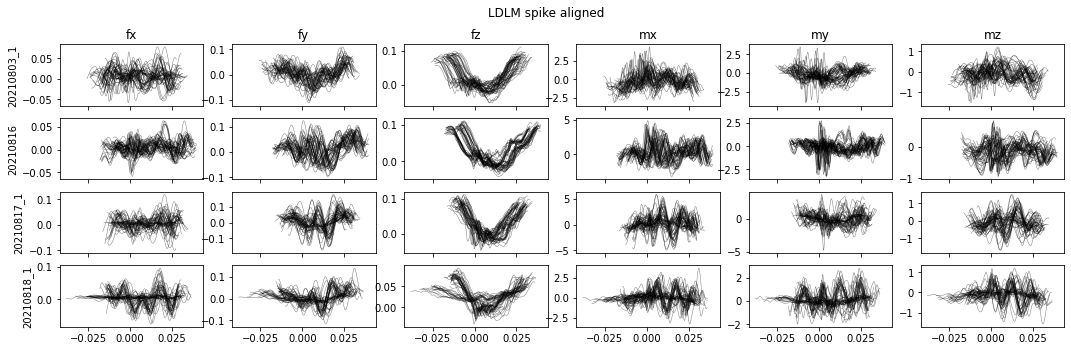

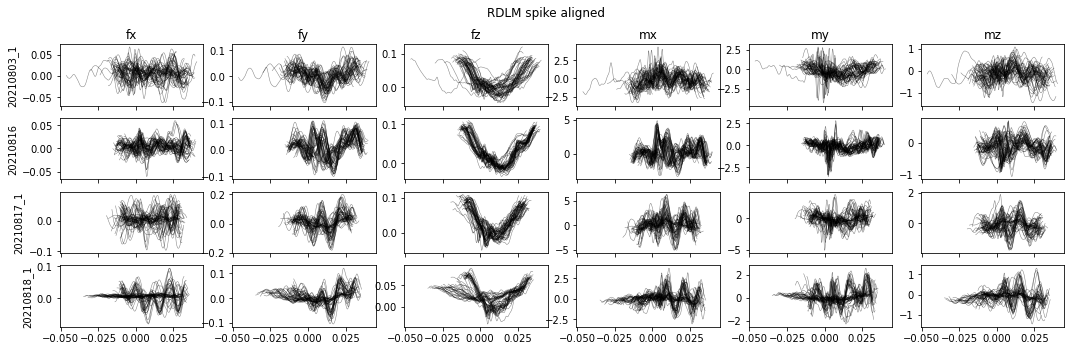

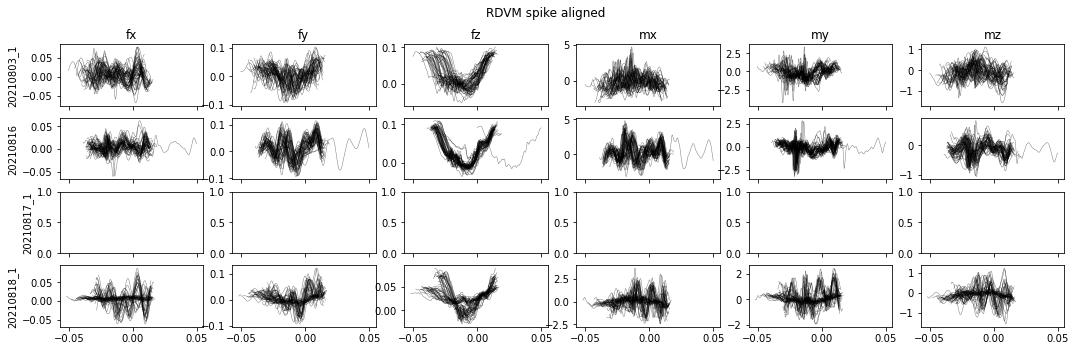

In [5]:
nwb = 50 # How many wingbeats to sample
fsize = (18, 5.2)

#--- Fz phase aligned
fig, ax = plt.subplots(len(runDates), len(channelsFT), figsize=fsize, sharex=True)
for i,d in enumerate(runDates):
    # grab this date
    dt = df.loc[(df.date==d) & (df.wb<-1),].copy()
    # Index the groups, select random subset
    g = dt.groupby(['pulse','wb'])
    a = np.arange(g.ngroups)
    np.random.shuffle(a)
    dt = dt[g.ngroup().isin(a[:nwb])]
    # Loop over randomly chosen groups and plotting variables, and plot
    for name, group in dt.groupby(['pulse','wb']):
        for j,m in enumerate(channelsFT):
            ax[i,j].plot(group.phase, group[m],
                         lw=0.5, alpha=0.5, color='black')
fig.suptitle(r'$F_z$ phase aligned')
for i,m in enumerate(channelsFT):
    ax[0,i].set_title(m)
for i,d in enumerate(runDates):
    ax[i,0].set_ylabel(d)

#--- First spike aligned
for alignMuscle in channelsEMG:
    fig, ax = plt.subplots(len(runDates), len(channelsFT), figsize=fsize, sharex=True)
    for i,d in enumerate(runDates):
        # Grab data
        dt = df.loc[(df.date==d) & (df.wb<-1) & (~np.isnan(df[alignMuscle+'_fs']))].copy()
        # Continue only if aligning muscle had data 
        if len(dt)!=0:
            # Index the groups, select random subset
            g = dt.groupby(['pulse','wb'])
            a = np.arange(g.ngroups)
            np.random.shuffle(a)
            dt = dt[g.ngroup().isin(a[:nwb])]
            # Loop over randomly chosen groups and plotting variables, and plot
            for name, group in dt.groupby(['pulse','wb']):
                for j,m in enumerate(channelsFT):
                    ax[i,j].plot(group.Time-group.Time.iloc[int(group[alignMuscle+'_fs'].iloc[0])],
                                group[m],
                                lw=0.5, alpha=0.5, color='black')
    fig.suptitle(alignMuscle+' spike aligned')
    for i,m in enumerate(channelsFT):
        ax[0,i].set_title(m)
    for i,d in enumerate(runDates):
        ax[i,0].set_ylabel(d)


# Top-down contour plots of torque traces separated by some variable
General method for taking a start point (spike triggered, stim triggered, wingbeat, etc), a separating variable (like mean torque, or induced spike time difference), and plotting torque traces over time in 3D represenation

***TODO***: 
- Make sure this is actually the right data: Recreate the stimphase vs. spikephase plot to verify. 
- Try other alignment methods, aligning off of arbitrary different variables
- Change to not just interpolate, instead plot raw traces top-down with color tied to z height

processing and plotting 20210803_1
processing and plotting 20210816
processing and plotting 20210817_1
processing and plotting 20210818_1


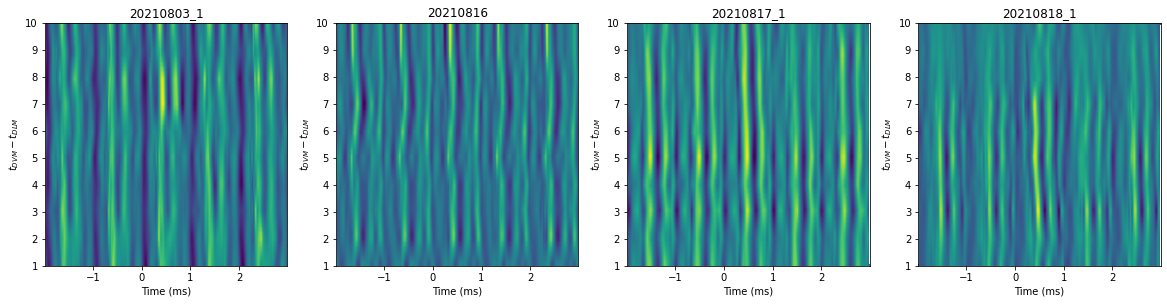

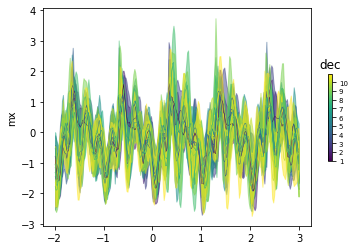

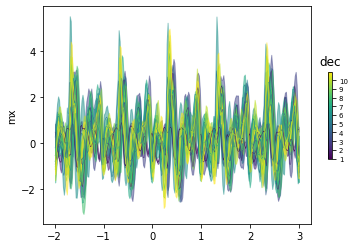

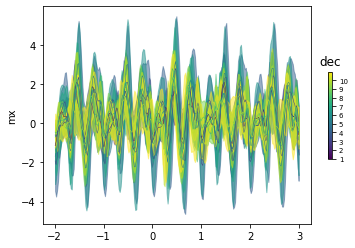

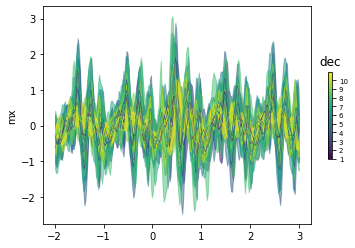

In [101]:
usewb = (-2, 3) # ignore all wingbeat except in this range
usewindow = (-200, 200) # ms, window to actually observe around zero'd time
ngridx, ngridy = 250, 50

fig, ax = plt.subplots(1, len(runDates), figsize=(20,5))
# Loop over dates
for di,d in enumerate(runDates):
    print('processing and plotting '+d)
    # make dataframe subset
    dt = df.loc[(df.date==d) & 
                (df.wb>=usewb[0]) & 
                (df.wb<usewb[1]) & 
                (df.stimphase<0.5)].copy()
    # Zero time, trim data to region around t=0, change phase to be unique for each wb
    dt.Time = dt.groupby(['date','pulse'], group_keys=False).apply(
        lambda g: g['Time'] - g.loc[(g.wb==0), 'Time'].iloc[0])
        # lambda g: g['Time'] - (g.loc[(g.wb==-1), 'Time'].iloc[0] + g.loc[g.wb==-1,'LDVM_fs'].iloc[0]/fsamp))
    dt = dt.loc[(dt.Time>=usewindow[0]/1000) & (dt.Time<=usewindow[1]/1000)]
    dt.phase = dt.phase + dt.wb
    # Generate y axis vector
    dt['yvar'] = 0
    dt['yvar'] = dt.groupby(['date','pulse'], group_keys=False).apply(
        # lambda g: g.yvar + (g.loc[g.wbstate=='stim', 'tdl'].iloc[0] - g.loc[g.wb==-1, 'tdl'].iloc[0]))
        lambda g: g.yvar + g.loc[g.wbstate=='stim', 'tdl'].iloc[0])
        # lambda g: g.yvar + (g.loc[g.wbstate=='stim', 'LDVM_fs'].iloc[0] - g.loc[g.wbstate=='stim', 'LDLM_fs'].iloc[0])/len(g.loc[g.wbstate=='stim']))
    dt = dt.loc[~np.isnan(dt.yvar)]
    # Split by deciles
    dec = np.percentile(dt.yvar, np.arange(0, 100, 10))
    dt['dec'] = np.digitize(dt.yvar, dec)
    # Get mean waveforms for each decile
    xl,yl,gl = binPlot(dt, 'phase', ['mx'], 'dec', 'dec', ngridx+1)
    # Rearrange binned waveforms into matrix for interpolation
    mat = np.zeros((3,ngridx*len(dec)))
    i = 0
    for j in range(len(gl)):
        glen = len(xl[j])
        mat[0,i:i+glen] = xl[j]['mean'] # X
        mat[1,i:i+glen] = gl[j] # Y
        mat[2,i:i+glen] = yl[j]['mean'] # Z
        i += glen
    # mat = mat[:, mat[1,:]<30]
    # Make grid to draw image on
    xmin, xmax = np.min(mat[0,:]), np.max(mat[0,:])
    ymin, ymax = np.min(mat[1,:]), np.max(mat[1,:])
    gridx, gridy = np.mgrid[xmin:xmax:ngridx*1j, ymin:ymax:ngridy*1j]
    gridz = griddata(mat[0:2,:].T, mat[2,:], (gridx,gridy), method='linear')
    # Plot!
    ax[di].imshow(gridz.T, extent=[xmin, xmax, ymin, ymax], origin='lower', aspect=(xmax-xmin)/(ymax-ymin))
    # Labels
    ax[di].set_title(d)
    ax[di].set_xlabel('Time (ms)')
    ax[di].set_ylabel(r'$t_{DVM}-t_{DLM}$')


The problem? So far nothing really stands out. No consistent trends, at least aligned along the axis of DVM-DLM timing differences, induced or otherwise. Might rewrite to take a summary statistic in each location (like a mean) but unlikely to show much more

Levels of sophistication needed. Spike-triggered, time-domain might be fine when separated into deciles of wingbeat frequency

Creation of phase column based on spike times? 0-1 from first spike to first spike?

# Recreate waveforms sorted by $\Delta t$ decile plot

Text(0.5, 1.0, '$\\Delta (t_{DVM}-t_{DLM})$')

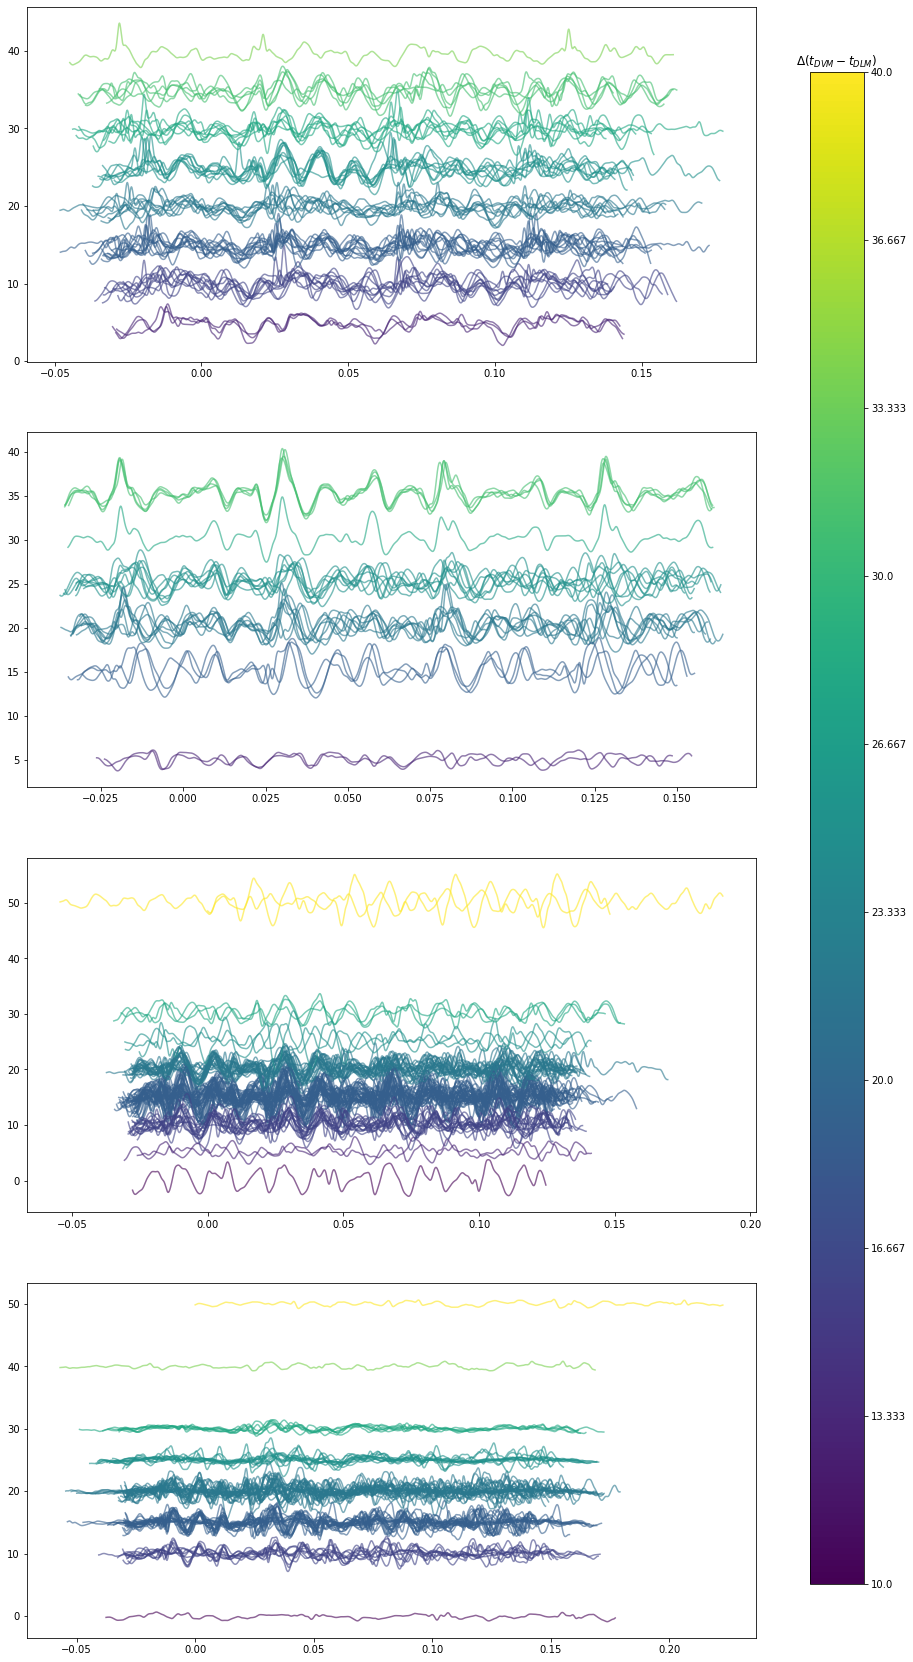

In [116]:
usewb = (-1, 3) # ignore all wingbeat except in this range
nbin = 10
# bins = np.linspace(-3, 16, nbin)
bins = np.linspace(10, 40, nbin)

fig, ax = plt.subplots(len(runDates), 1, figsize=(15,30))
viridis = cmx.get_cmap('viridis')

# Loop over dates
for di,d in enumerate(runDates):
    # make dataframe subset
    dt = df.loc[(df.date==d) & 
                (df.wb>=usewb[0]) & 
                (df.wb<usewb[1]) & 
                (df.stimphase<0.5)].copy()
    # Zero time, trim data to region around t=0
    dt.Time = dt.groupby(['date','pulse'], group_keys=False).apply(
        # lambda g: g['Time'] - g.loc[(g.wb==0), 'Time'].iloc[0])
        lambda g: g['Time'] - (g.loc[(g.wb==-1), 'Time'].iloc[0] + g.loc[g.wb==-1,'LDVM_fs'].iloc[0]/fsamp))
    # Preallocate/prepare for loop
    grouped_df = dt.groupby(['date','pulse'])
    ngroup, groupsize = grouped_df.ngroups, np.max(grouped_df.size())
    vals = []
    # Loop over each pulse, add to matrix
    for name, g in grouped_df:
        # thiscol = g.loc[g.wbstate=='stim', 'tdl'].iloc[0] - g.loc[g.wb==-1, 'tdl'].iloc[0]
        thiscol = g.loc[g.wbstate=='stim', 'tdl'].iloc[0]
        # thiscol = (g.loc[g.wbstate=='stim', 'LDVM_fs'].iloc[0] - g.loc[g.wbstate=='stim', 'LDLM_fs'].iloc[0])/len(g.loc[g.wbstate=='stim'])
        vals.append(thiscol)
        thisbin = np.digitize(thiscol, bins)
        # ax[di].plot(g.phase+g.wb, g.mx+5*thisbin, color=viridis(thisbin/nbin), alpha=0.6)
        ax[di].plot(g.Time, g.mx+5*thisbin, color=viridis(thisbin/nbin), alpha=0.6)
# Colorbar
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
mincol, maxcol = bins[0], bins[-1]
cbar = fig.colorbar(cmx.ScalarMappable(norm=None, cmap=viridis),
                    ticks=(bins-mincol)/(maxcol-mincol),
                    cax=cbar_ax)
cbar.ax.set_yticklabels([str(round(x,3)) for x in bins])
cbar.ax.set_title(r'$\Delta (t_{DVM}-t_{DLM})$')

# PCA of torque waveforns

Text(0, 0.5, 'Explained Variance')

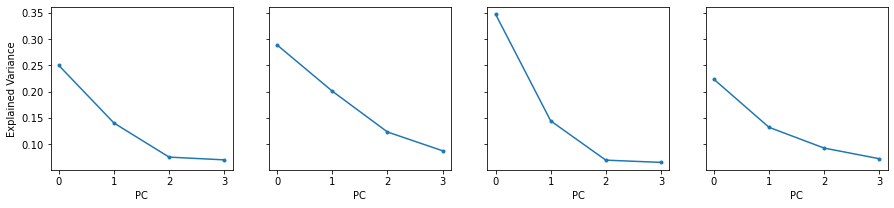

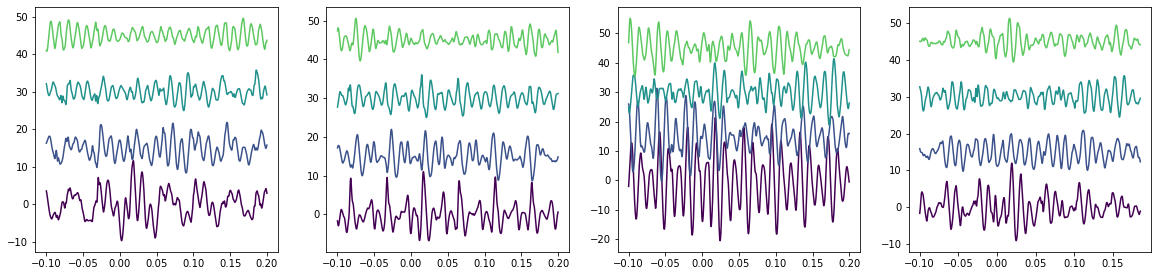

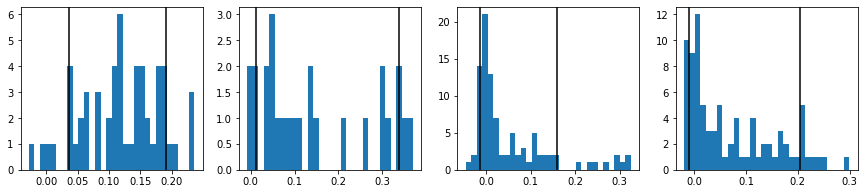

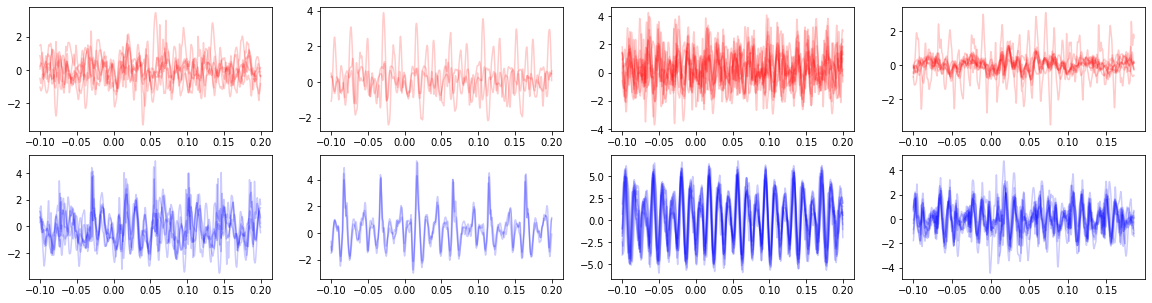

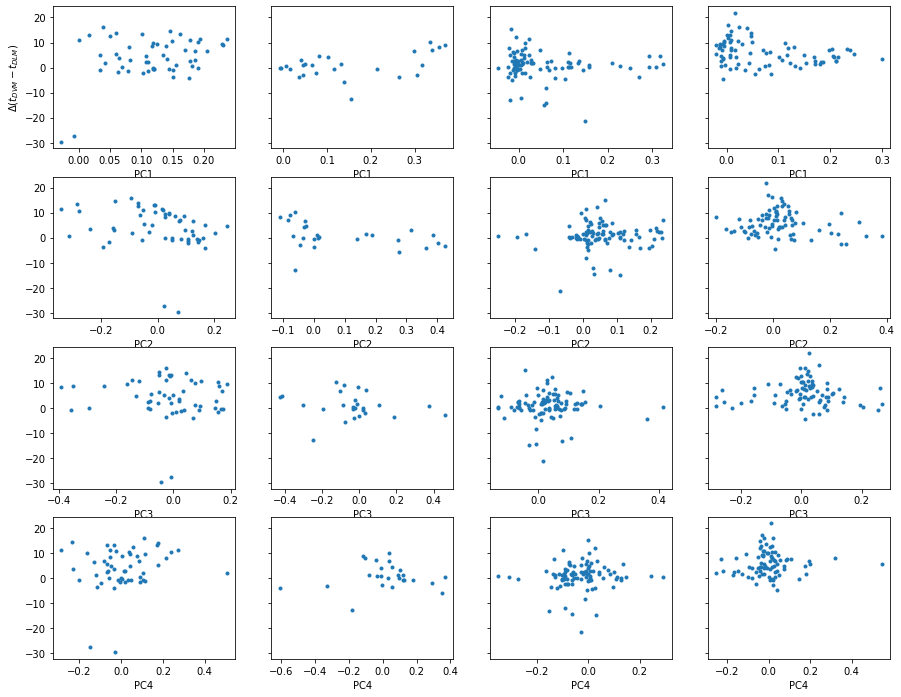

In [105]:
ncomp = 4
usewb = (-3, 6) # ignore all wingbeat except in this range
usewindow = (-100, 200) # ms, window to actually observe around zero'd time

# Figure parameters
viridis = cmx.get_cmap('viridis')
fw, fh = 15, 3
# Create figures
fev, axev = plt.subplots(1, len(runDates), figsize=(fw,fh), sharey=True) # explained variance
fpc, axpc = plt.subplots(1, len(runDates), figsize=(20,4.5)) # main PC's
fpc1dist, axpc1dist = plt.subplots(1, len(runDates), figsize=(fw,fh)) # PC1 distribution
fpc1, axpc1 = plt.subplots(2, len(runDates), figsize=(20,5)) # PC1 deciles
figstim, axstim = plt.subplots(len(runDates), ncomp, figsize=(15,12), sharey=True) # PC loadings against stimulus variable (DLM-DVM timing, for instance)
# Loop over dates
for di,d in enumerate(runDates):
    # make dataframe subset
    dt = df.loc[(df.date==d) & 
                (df.wb>=usewb[0]) & 
                (df.wb<usewb[1]) & 
                (df.stimphase<0.5)].copy()
    # Zero time, trim data to region around t=0
    dt.Time = dt.groupby(['date','pulse'], group_keys=False).apply(
        lambda g: g['Time'] - g.loc[(g.wb==0), 'Time'].iloc[0])
        # lambda g: g['Time'] - (g.loc[(g.wb==-1), 'Time'].iloc[0] + g.loc[g.wb==-1,'LDVM_fs'].iloc[0]/fsamp))
    dt = dt.loc[(dt.Time>=usewindow[0]/1000) & (dt.Time<=usewindow[1]/1000)]
    # Group dataframe, prepare for loop
    grouped_df = dt.groupby(['date','pulse'])
    ngroup, groupsize = grouped_df.ngroups, np.max(grouped_df.size())
    mat = np.full((ngroup,groupsize), np.nan)
    stimvar = np.zeros(ngroup)
    # Loop over each pulse, add to matrix
    for i, (name, g) in enumerate(grouped_df):
        vec = g
        mat[i,0:len(vec)] = vec.mx
        stimvar[i] = g.loc[g.wbstate=='stim', 'tdl'].iloc[0] - g.loc[g.wb==-1, 'tdl'].iloc[0]
        # stimvar[i] = g.loc[g.wbstate=='stim', 'tdl'].iloc[0]
        # stimvar[i] = g.loc[g.wbstate=='stim', 'stimphase'].iloc[0]
    # Create time vector 
    # tvec = np.linspace(0, (mat.shape[1]-1)/fsamp, mat.shape[1])
    tvec = np.arange(usewindow[0]/1000, usewindow[1]/1000, 1/fsamp)
    # Trim nan points (in the future can interpolate nans?)
    tvec = tvec[~np.isnan(mat).any(axis=0)]
    mat = mat[:, ~np.isnan(mat).any(axis=0)]

    # Take PCA
    pca = PCA(n_components=ncomp)
    pc = pca.fit_transform(mat.T)
    
    # Plot stimvar against each PC
    for i in range(ncomp):
        axstim[i,di].plot(pca.components_[i,:], stimvar, '.')
    # Plot labels
    if di==(len(runDates)-1):
        for i in range(ncomp):
            axstim[i,di].set_xlabel('PC'+str(i+1))
    axstim[di,0].set_ylabel(r'$\Delta (t_{DVM}-t_{DLM})$')
    
    # Plot explained variance
    axev[di].plot(pca.explained_variance_ratio_, '.-')
    axev[di].set_xlabel('PC')
    # Plot main PC's
    for i in range(pc.shape[1]):
        axpc[di].plot(tvec, pc[:,i]+i*15, color=viridis(i/pc.shape[1]))
    # Plot distribution of PC1
    deciles = np.percentile(pca.components_[0,:], np.arange(0, 100, 10))
    axpc1dist[di].hist(pca.components_[0,:], bins=30)
    axpc1dist[di].axvline(x=deciles[1], color='black')
    axpc1dist[di].axvline(x=deciles[-1], color='black')
    # Get which traces are in lower and upper percentile, plot those
    for j in np.where(pca.components_[0,:]<=deciles[1])[0]:
        axpc1[0,di].plot(tvec, mat[j,:], color='red', alpha=0.2)
    for j in np.where(pca.components_[0,:]>=deciles[-1])[0]:
        axpc1[1,di].plot(tvec, mat[j,:], color='blue', alpha=0.2)
# Labels
axev[0].set_ylabel('Explained Variance')


Look at how PC's vary with stimulation spike times

# $(t_{DVM}-t_{DLM})$ vs stimphase:
How well does the actual stimulus phase connect to DVM-DLM timing difference? Not important, but just curious

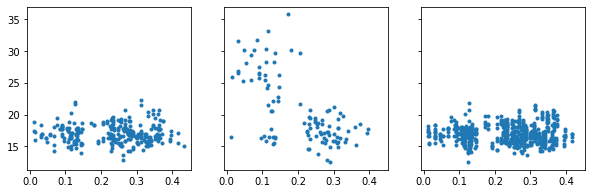

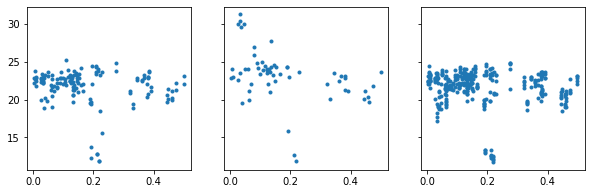

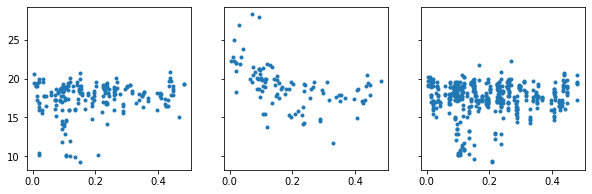

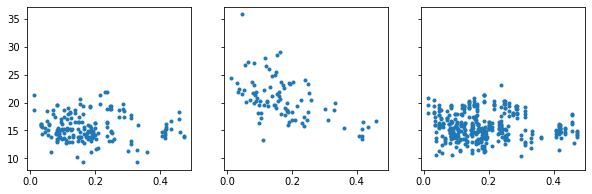

In [163]:
ncomp = 4
usewb = (-2, 6)

aggdict = {}
aggdict['wbstate'] = 'first'
aggdict['stimphase'] = 'first'
aggdict['tdl'] = 'first'
aggdict['tdr'] = 'first'

# Loop over dates
for d in runDates:
    # make dataframe subset
    dt = df.loc[(df.date==d) & 
                (df.wb>=usewb[0]) & 
                (df.wb<usewb[1]) & 
                (df.stimphase<0.5)].copy()
    
    g = dt.groupby(['date','pulse','wb']).aggregate(aggdict)
    
    fig, ax = plt.subplots(1, 3, figsize=(10,3), sharex=True, sharey=True)
    for i,state in enumerate(['pre','stim','post']):
        dsub = g.loc[g.wbstate==state]
        ax[i].plot(dsub.stimphase, dsub.tdl, '.')

# Quick look: Does wingbeat frequency/period vary with stimulation-induced change in spike time?

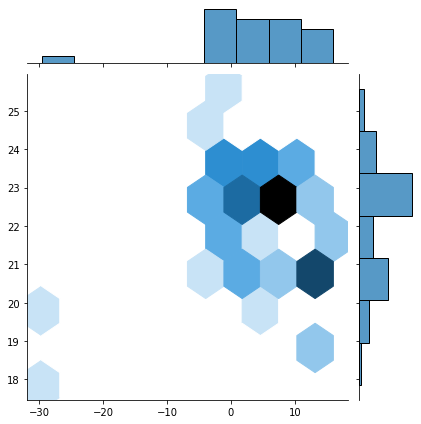

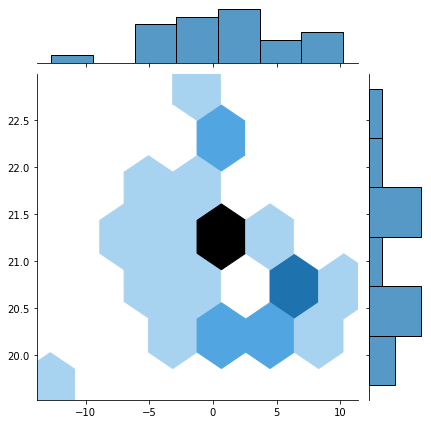

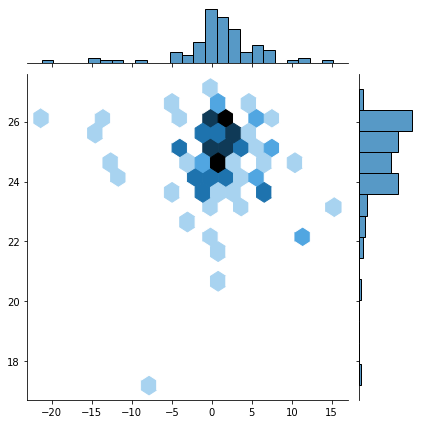

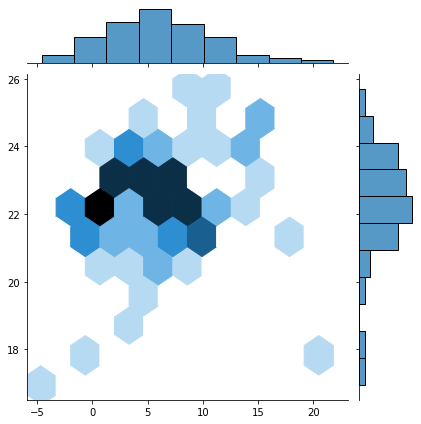

In [110]:
usewb = (-2, 2) # ignore all wingbeat except in this range
# Loop over dates
for di,d in enumerate(runDates):
    # make dataframe subset
    dt = df.loc[(df.date==d) & 
                (df.wb>=usewb[0]) & 
                (df.wb<usewb[1]) & 
                (df.stimphase<0.5)].copy()
    # Preallocate/prepare for loop
    grouped_df = dt.groupby(['date','pulse'])
    deltaT = []
    wbf = []
    # Loop over each pulse, add to matrix
    for name, g in grouped_df:
        deltaT.append(g.loc[g.wbstate=='stim', 'tdl'].iloc[0] - g.loc[g.wb==-1, 'tdl'].iloc[0])
        # thiscol = g.loc[g.wbstate=='stim', 'tdl'].iloc[0]
        # thiscol = (g.loc[g.wbstate=='stim', 'LDVM_fs'].iloc[0] - g.loc[g.wbstate=='stim', 'LDLM_fs'].iloc[0])/len(g.loc[g.wbstate=='stim'])
        wbf.append(1/(len(g.loc[g.wbstate=='stim'])/fsamp))
    sns.jointplot(x=deltaT, y=wbf, kind='hex')

# How wingbeat period/frequency ($F_z$ cycles) is impacted by stimulation

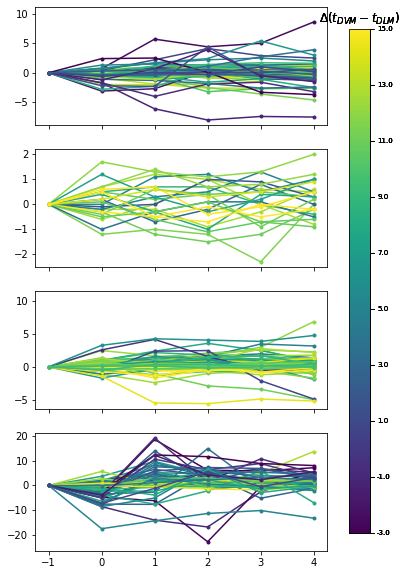

In [43]:
plt.close('all')
usewb = (-1, 5) # ignore all wingbeat except in this range
fig, ax  = plt.subplots(len(runDates), 2, sharex=True, figsize=(12,10))
# Loop over dates
for ind,d in enumerate(runDates):
    # make dataframe subset
    dt = df.loc[(df.date==d) & 
                (df.wb>=usewb[0]) & 
                (df.wb<usewb[1]) & 
                (df.stimphase<0.5)].copy()
    # Color setup
    viridis = cmx.get_cmap('viridis')
    maxcol, mincol = 15, -3
    # Zero time
    dt.Time = dt.groupby(['date','pulse'], group_keys=False).apply(
        lambda g: g['Time'] - g.loc[(g.wb==0), 'Time'].iloc[0])
    # Preallocate/prepare for loop
    grouped_df = dt.groupby(['date','pulse'])
    ngroup, groupsize = grouped_df.ngroups, np.max(grouped_df.size())
    # Loop over each pulse, add to matrix
    for name, g in dt.groupby(['date','pulse']):
        # Loop over left and right
        for lri,lr in enumerate(['l','r']):
            thiscol = g.loc[g.wbstate=='stim', 'td'+lr].iloc[0] - g.loc[g.wb==-1, 'td'+lr].iloc[0]
            # thiscol = g.loc[g.wbstate=='stim', 'tdr'].iloc[0]
            # thiscol = (g.loc[g.wbstate=='stim', 'LDVM_fs'].iloc[0] - g.loc[g.wbstate=='stim', 'LDLM_fs'].iloc[0])/len(g.loc[g.wbstate=='stim'])
            dg = g.groupby('wb').size()
            ax[ind,lri].plot(dg.index, (dg.values-dg.values[0])/10, '.-',
                                color=viridis((maxcol-thiscol)/(maxcol-mincol)))
# Labels
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
tickrange = np.linspace(mincol, maxcol, 10)
cbar = fig.colorbar(cmx.ScalarMappable(norm=None, cmap=viridis),
                    ticks=(tickrange-mincol)/(maxcol-mincol),
                    cax=cbar_ax)
cbar.ax.set_yticklabels([str(round(x,3)) for x in tickrange], fontsize=7)
cbar.ax.set_title(r'$\Delta (t_{DVM}-t_{DLM})$')

# How DLM-DVM timing changes after stimulation

/var/folders/wk/44b_fwgs06q9gfdjtfs124640000gp/T/ipykernel_74130/3387694168.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  axd[len(runDates)-1].set_xticklabels(


[Text(-4.0, 0, '-4--3'),
 Text(-3.0, 0, '-3--2'),
 Text(-2.0, 0, '-2--1'),
 Text(-1.0, 0, '-1-0'),
 Text(0.0, 0, '0-1'),
 Text(1.0, 0, '1-2'),
 Text(2.0, 0, '2-3'),
 Text(3.0, 0, '3-4'),
 Text(4.0, 0, '4-5')]

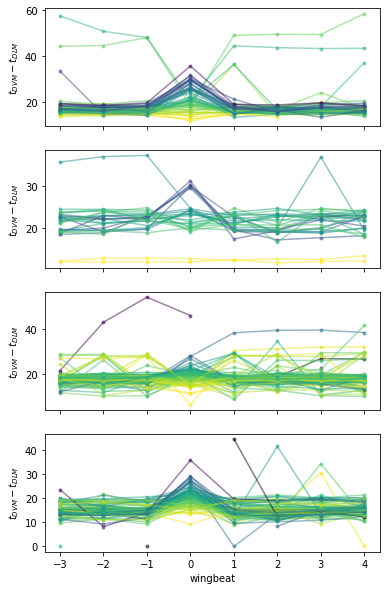

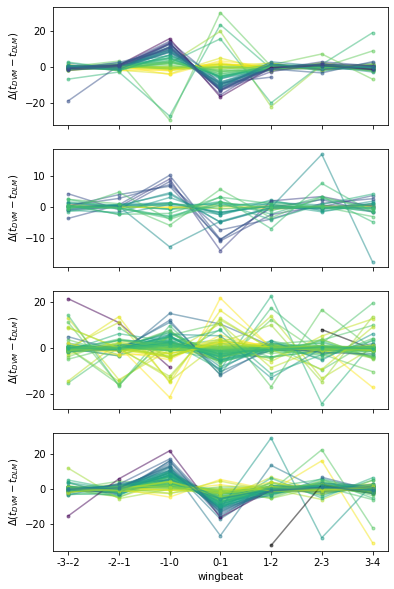

In [46]:
usewb = (-3, 5) # ignore all wingbeat except in this range
viridis = cmx.get_cmap('viridis')
maxcol, mincol = 36, 13
fig, ax  = plt.subplots(len(runDates), 1, sharex=True, figsize=(6,10))
figd, axd  = plt.subplots(len(runDates), 1, sharex=True, figsize=(6,10))
# Loop over dates
for ind,d in enumerate(runDates):
    # make dataframe subset
    dt = df.loc[(df.date==d) & 
                (df.wb>=usewb[0]) & 
                (df.wb<usewb[1]) & 
                (df.stimphase<0.5)].copy()
    # Loop over each pulse, add to matrix
    for name, g in dt.groupby(['date','pulse']):
        thiscol = g.loc[g.wbstate=='stim', 'tdl'].iloc[0]
        dg = g.groupby('wb').aggregate({'wb' : 'first',
                                        'tdl' : 'first'})
        ax[ind].plot(dg.wb, dg.tdl, '.-',
                     color=viridis((maxcol-thiscol)/(maxcol-mincol)),
                     alpha=0.5)
        axd[ind].plot(dg.wb.to_numpy()[:-1], np.diff(dg.tdl), '.-',
                      color=viridis((maxcol-thiscol)/(maxcol-mincol)),
                      alpha=0.5)
    ax[ind].set_ylabel(r'$t_{DVM}-t_{DLM}$')
    axd[ind].set_ylabel(r'$\Delta (t_{DVM}-t_{DLM})$')
# Labels
ax[len(runDates)-1].set_xlabel('wingbeat')
axd[len(runDates)-1].set_xlabel('wingbeat')
axd[len(runDates)-1].set_xticklabels(
    labels=[str(x)+'-'+str(x+1) for x in np.arange(usewb[0]-1,usewb[1])])




To illustrate what's going on in weird trials let's pick a few really odd ones:

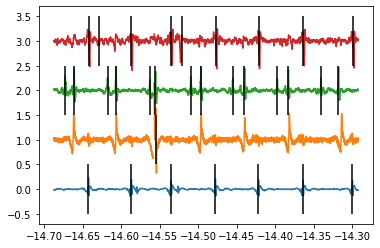

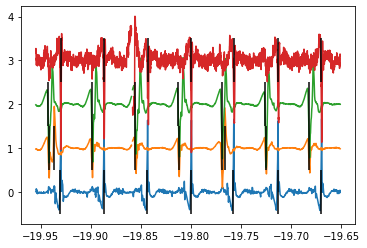

In [42]:
# Really high delta t:
dt = df.loc[
    (df.wb>=usewb[0]) & 
    (df.wb<usewb[1]) & 
    (df.stimphase<0.5) & 
    (df.date=='20210803_1') &
    (df.pulse==19)].copy()
plt.figure()
for i,m in enumerate(channelsEMG):
    plt.plot(dt.Time, dt[m]+i)
    plt.vlines(x=dt.loc[dt[m+'_st'], 'Time'], ymin=i-0.5, ymax=i+0.5, color='black', zorder=3)
# Really low delta t:
dt = df.loc[
    (df.wb>=usewb[0]) & 
    (df.wb<usewb[1]) & 
    (df.stimphase<0.5) & 
    (df.date=='20210816') &
    (df.pulse==26)].copy()
plt.figure()
for i,m in enumerate(channelsEMG):
    plt.plot(dt.Time, dt[m]+i)
    plt.vlines(x=dt.loc[dt[m+'_st'], 'Time'], ymin=i-0.5, ymax=i+0.5, color='black', zorder=3)

# General notes

- Could use a more general-purpose function to split cycles by any variable or criterion, and return a new dataframe column of wingbeats from that cycle-splitting metric. What if I want to use the hilbert transform of a 20Hz bandpass filtered $M_x$ (or any force or torque)? What about aligning by first or second spike of a given muscle?
- Need way to take stimulation delays that are very long and loop them back around, offset. 

# Ideas

- Align by _mean_ spike time for pre-stim spikes